# Mini Laboratório: Explorando os Datasets (BEIR)

Este notebook oferece uma análise exploratória prática dos datasets suportados (`SciFact`, `FIQA`, `NFCorpus`) no formato **BEIR**. Vamos:

- Carregar `corpus`, `queries` e `qrels`
- Inspecionar amostras
- Ver estatísticas simples (tamanhos, distribuição por split)
- Cruzar `qrels` com `corpus` para ver documentos relevantes por query
- Converter para objetos tipados (`Document`, `Query`) usados no código

## Requisitos

- Estrutura de dados gerada pelo script:
  - `python download_datasets.py --datasets scifact,fiqa,nfcorpus --root ./data --format parquet`
- Dependências principais: `pandas`, `pyarrow` (para Parquet)

## Organização
- `corpus.parquet`: documentos (`doc_id`, `title`, `text`, `metadata`)
- `queries.parquet`: consultas (`query_id`, `query`)
- `qrels.parquet`: julgamentos de relevância (`query_id`, `doc_id`, `score`, `split`)

In [25]:
import sys
from pathlib import Path

repo_root = Path.cwd().parent.parent  

repo_root_str = str(repo_root)
if repo_root_str not in sys.path:
    sys.path.insert(0, repo_root_str)

import pandas as pd
pd.set_option("display.max_colwidth", 120)

from src.datasets.loader import load_beir_dataset, select_split, as_documents, as_queries

## Seleção do Dataset e Carregamento

Escolha um dos datasets: `scifact`, `fiqa`, `nfcorpus`. 
O caminho esperado é `data/{dataset}/processed/beir`.

In [8]:
# Escolha aqui: "scifact", "fiqa" ou "nfcorpus"
dataset_name = "scifact"

data_root = repo_root / "data" / dataset_name / "processed" / "beir"
corpus_df, queries_df, qrels_df = load_beir_dataset(data_root)

print(f"Dataset: {dataset_name}")
print(f"- corpus:  {len(corpus_df):,} docs")
print(f"- queries: {len(queries_df):,} queries")
print(f"- qrels:   {len(qrels_df):,} pairs")
print("Splits em qrels:", sorted(qrels_df['split'].unique().tolist()))

Dataset: scifact
- corpus:  5,183 docs
- queries: 1,109 queries
- qrels:   1,258 pairs
Splits em qrels: ['test', 'train']


## Visão rápida dos dados

Amostras de `corpus`, `queries` e `qrels` para entender os campos principais.

In [9]:
display(corpus_df.sample(min(3, len(corpus_df))))
display(queries_df.sample(min(3, len(queries_df))))
display(qrels_df.sample(min(5, len(qrels_df))))

,doc_id,title,text,metadata
3382,22942787,Relation between Medicare screening reimbursement and stage at diagnosis for older patients with colon cancer.,CONTEXT Medicare's reimbursement policy was changed in 1998 to provide coverage for screening colonoscopies for pati...,{}
3814,25816994,"Renal outcomes with telmisartan, ramipril, or both, in people at high vascular risk (the ONTARGET study): a multicen...",BACKGROUND Angiotensin receptor blockers (ARB) and angiotensin converting enzyme (ACE) inhibitors are known to reduc...,{}
764,4345605,Control of cortical GABA circuitry development by Nrg1 and ErbB4 signalling,Schizophrenia is a complex disorder that interferes with the function of several brain systems required for cognitio...,{}


,query_id,query
321,564,"In British Men, haplogroup I increases risk of cardiovascular disease by 50%."
977,783,Mice without IFN-γ or its receptor are resistant to EAM induced with α-MyHC/CFA.
866,248,Chenodeosycholic acid treatment increases whole-body energy expenditure.


,query_id,doc_id,score,split
995,275,14819804,1,test
274,414,6309659,1,train
763,1171,18956141,1,train
393,612,9638032,1,train
806,1236,17973161,1,train


## Seleção de Split

Selecionamos um split preferencial (por padrão: `test` → `dev` → `validation` → `train`) e filtramos `qrels`.

In [28]:
split = select_split(qrels_df, prefer=("test", "dev", "validation", "train"))
qrels_split = qrels_df[qrels_df["split"] == split].copy()

print("Split escolhido:", split)
print("Tamanho do split:", len(qrels_split))

num_unique_query_ids = qrels_split["query_id"].nunique()
print(f"Número de query_id distintos em qrels_split: {num_unique_query_ids}")


# Garantir consistência de chaves entre qrels e tabelas
missing_docs = ~qrels_split["doc_id"].isin(corpus_df["doc_id"])
missing_queries = ~qrels_split["query_id"].isin(queries_df["query_id"])
print("Qrels com doc_id não encontrado no corpus:", missing_docs.sum())
print("Qrels com query_id não encontrado em queries:", missing_queries.sum())

Split escolhido: test
Tamanho do split: 339
Número de query_id distintos em qrels_split: 300
Qrels com doc_id não encontrado no corpus: 0
Qrels com query_id não encontrado em queries: 0


## Uma query e seus documentos relevantes

Selecionamos uma `query` do split e unimos com `corpus` via `qrels` para ver os documentos relevantes.

In [17]:
# Escolher uma query do split atual
qid = qrels_split["query_id"].iloc[5]
query_text = queries_df.loc[queries_df["query_id"] == qid, "query"].values[0]

print("Query ID:", qid)
print("Query:", query_text)

# Pegar documentos relevantes
rel_docs = (
    qrels_split[qrels_split["query_id"] == qid]
    .merge(corpus_df, how="left", on="doc_id")
    .sort_values("score", ascending=False)
)

# Mostrar os top-5 relevantes desta query
def truncate(t, n=300):
    return (t[:n] + " ...") if isinstance(t, str) and len(t) > n else t

display(
    rel_docs[["doc_id", "score", "title", "text"]]
    .head(5)
    .assign(title=lambda d: d["title"].apply(lambda x: truncate(str(x), 100)))
    .assign(text=lambda d: d["text"].apply(lambda x: truncate(str(x), 300)))
)

Query ID: 36
Query: A deficiency of vitamin B12 increases blood levels of homocysteine.


,doc_id,score,title,text
0,5152028,1,Folic acid improves endothelial function in coronary artery disease via mechanisms largely independe ...,"BACKGROUND Homocysteine is a risk factor for coronary artery disease (CAD), although a causal relation remains to be..."
1,11705328,1,Randomized trial of folic acid supplementation and serum homocysteine levels.,BACKGROUND Lowering serum homocysteine levels with folic acid is expected to reduce mortality from ischemic heart di...


## Estatísticas simples

- Tamanhos médios de documento e query (em tokens simples por espaço)
- Distribuição de `score` em `qrels`

In [18]:
# Tamanhos (tokens aproximados por split de espaço)
corpus_len = corpus_df["text"].fillna("").str.split().str.len()
query_len = queries_df["query"].fillna("").str.split().str.len()

stats = {
    "docs_count": len(corpus_df),
    "queries_count": len(queries_df),
    "qrels_count": len(qrels_df),
    "doc_len_avg": float(corpus_len.mean()),
    "doc_len_median": float(corpus_len.median()),
    "query_len_avg": float(query_len.mean()),
    "query_len_median": float(query_len.median()),
}

print(stats)

# Distribuição de score
score_counts = qrels_df["score"].value_counts().sort_index()
print("\nDistribuição de score em qrels:")
display(score_counts)

{'docs_count': 5183, 'queries_count': 1109, 'qrels_count': 1258, 'doc_len_avg': 201.81092031641907, 'doc_len_median': 192.0, 'query_len_avg': 12.379621280432822, 'query_len_median': 12.0}

Distribuição de score em qrels:


score
1    1258
Name: count, dtype: int64

## Visualizações rápidas

Histogramas dos comprimentos de documentos e queries.

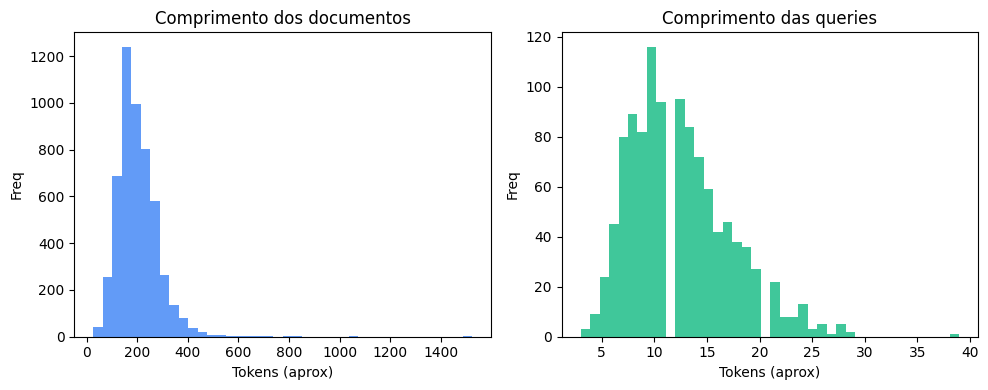

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(corpus_len, bins=40, color="#3b82f6", alpha=0.8)
axes[0].set_title("Comprimento dos documentos")
axes[0].set_xlabel("Tokens (aprox)")
axes[0].set_ylabel("Freq")

axes[1].hist(query_len, bins=40, color="#10b981", alpha=0.8)
axes[1].set_title("Comprimento das queries")
axes[1].set_xlabel("Tokens (aprox)")
axes[1].set_ylabel("Freq")

plt.tight_layout()
plt.show()

## Conversão para objetos tipados (`Document`, `Query`)

Útil para integrar com os retrievers ou pipelines que usam o schema do projeto.

In [22]:
docs = as_documents(corpus_df)
qs = as_queries(queries_df)

print(f"Objetos: {len(docs)} Document, {len(qs)} Query")
print("Exemplo Document:", docs[0])
print("Exemplo Query:", qs[0])

Objetos: 5183 Document, 1109 Query
Exemplo Document: Document(doc_id='4983', title='Microstructural development of human newborn cerebral white matter assessed in vivo by diffusion tensor magnetic resonance imaging.', text='Alterations of the architecture of cerebral white matter in the developing human brain can affect cortical development and result in functional disabilities. A line scan diffusion-weighted magnetic resonance imaging (MRI) sequence with diffusion tensor analysis was applied to measure the apparent diffusion coefficient, to calculate relative anisotropy, and to delineate three-dimensional fiber architecture in cerebral white matter in preterm (n = 17) and full-term infants (n = 7). To assess effects of prematurity on cerebral white matter development, early gestation preterm infants (n = 10) were studied a second time at term. In the central white matter the mean apparent diffusion coefficient at 28 wk was high, 1.8 microm2/ms, and decreased toward term to 1.2 microm2